#  Multivariate Linear Regression using second-order optimizer L-BFGS 

In [3]:
from enum import Enum

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from torch import nn
from torch.optim import Optimizer

In [4]:
class Solution(Enum):
    UNACHIEVABLE = "Unachievable optimal solution"
    ACHIEVABLE = "Real data-generating process (DGP)"
    ANALYTIC = "Analytic solution (Matrix Inversion)"
    SGD = "First-order optimizer (SGD)"
    LBFGS = "Second-order optimizer (L-BFGS)"


METRICS = {
    "R2": r2_score,
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error,
    "MSE": mean_squared_error,
}

In [5]:
# General settings:
NUM_SAMPLES = 5
ADD_UNEXPLAINABLE_NOISE_TO_TARGETS = False
USE_ILL_CONDITIONED_FEATURE_MATRIX = False

# Hyperparameters for PyTorch models:
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE_SGD = 0.5
LEARNING_RATE_LBFGS = 0.5

METRIC_TO_PERFORM_FINAL_EVALUATION_ON = "R2"

np.random.seed(42)
torch.manual_seed(42)

## Dataset Creation

In [6]:
# Feature matrix "A" in linear equation "AX+U=B"
features = pd.DataFrame(
    data={
        "f1": np.random.randn(NUM_SAMPLES),
        "f2": np.random.randn(NUM_SAMPLES),
        "f3": np.random.randn(NUM_SAMPLES),
        "bias": np.ones(NUM_SAMPLES),
    },
    index=range(NUM_SAMPLES),
    dtype=float,
)

if USE_ILL_CONDITIONED_FEATURE_MATRIX:
    features["sum"] = features.sum(axis=1)

# Noise matrix "U" in linear equation "AX+U=B"
noise = pd.DataFrame(
    data=0.0,
    index=range(NUM_SAMPLES),
    columns=["t1", "t2"],
    dtype=float,
)

if ADD_UNEXPLAINABLE_NOISE_TO_TARGETS:
    # Add some unexplainable noise to t2
    noise["t2"] += np.random.randn(NUM_SAMPLES)

# Weight matrix "X" in linear equation "AX+U=B"
weights = pd.DataFrame(
    data=0.0,
    index=features.columns,
    columns=noise.columns,
    dtype=float,
)
# Fill X such that both t1 & t2 are a linear combination of f1 & f2 (all other features are irrelevant)
# t1 = 1*f1-2*f2
weights.loc["f1", "t1"] = 1
weights.loc["f2", "t1"] = -2
# t2 = 2*f1+3*f2
weights.loc["f1", "t2"] = 2
weights.loc["f2", "t2"] = 3

# Target matrix "B" in linear equation "AX+U=B"
# Calculate targets as in linear equation: B=AX
targets = features.dot(weights) + noise

print(
    f"Feature matrix A with m={features.shape[0]} rows (=samples) and "
    f"n={features.shape[1]} columns (=features):\n{features.to_string()}"
)
print(
    f"Weight matrix X with n={weights.shape[0]} rows (=features) and "
    f"o={weights.shape[1]} columns (=targets):\n{weights.to_string()}"
)
print(
    f"Noise matrix E with m={noise.shape[0]} rows (=samples) and "
    f"o={noise.shape[1]} columns (=targets):\n{noise.to_string()}"
)
print(
    f"Target matrix B with m={targets.shape[0]} rows (=samples) and "
    f"o={targets.shape[1]} columns (=targets):\n{targets.to_string()}"
)


Feature matrix A with m=5 rows (=samples) and n=4 columns (=features):
         f1        f2        f3  bias
0  0.496714 -0.234137 -0.463418   1.0
1 -0.138264  1.579213 -0.465730   1.0
2  0.647689  0.767435  0.241962   1.0
3  1.523030 -0.469474 -1.913280   1.0
4 -0.234153  0.542560 -1.724918   1.0
Weight matrix X with n=4 rows (=features) and o=2 columns (=targets):
       t1   t2
f1    1.0  2.0
f2   -2.0  3.0
f3    0.0  0.0
bias  0.0  0.0
Noise matrix E with m=5 rows (=samples) and o=2 columns (=targets):
    t1   t2
0  0.0  0.0
1  0.0  0.0
2  0.0  0.0
3  0.0  0.0
4  0.0  0.0
Target matrix B with m=5 rows (=samples) and o=2 columns (=targets):
         t1        t2
0  0.964988  0.291017
1 -3.296690  4.461110
2 -0.887181  3.597681
3  2.461979  1.637637
4 -1.319273  1.159373


## Initialize Comparison between the approaches

In [7]:
metric_comparison = {
    metric_name: pd.DataFrame(
        index=range(NUM_TRAIN_EPOCHS + 1),
        columns=[solution.value for solution in Solution],
    )
    for metric_name in METRICS.keys()
}

weights_comparison = {solution: weights for solution in Solution}


# Baseline: Unachievable solution
solution = Solution.UNACHIEVABLE
weights_comparison[solution] = weights

for metric_name, metric_function in METRICS.items():
    metric_comparison[metric_name].loc[:, solution.value] = metric_function(
        y_pred=targets,
        y_true=targets,
    )

# Baseline: Achievable solution
solution = Solution.ACHIEVABLE
weights_comparison[solution] = weights

for metric_name, metric_function in METRICS.items():
    metric_comparison[metric_name].loc[:, solution.value] = metric_function(
        y_pred=features.dot(weights_comparison[solution]),
        y_true=targets,
    )

## Approach 1: Analytic Solution

In [8]:
solution = Solution.ANALYTIC
print(solution)
print(f"Condition number of feature matrix = {np.linalg.cond(features)}")
quadratic_matrix = np.dot(features.T, features)
print(
    f"Condition number of quadratic matrix to be inverted = {np.linalg.cond(quadratic_matrix)}"
)
term_1 = np.linalg.inv(quadratic_matrix)
term_2 = np.dot(features.T, targets)
analytic_weights = np.dot(term_1, term_2)

weights_comparison[solution] = pd.DataFrame(
    analytic_weights,
    columns=weights.columns,
    index=weights.index,
)

for metric_name, metric_function in METRICS.items():
    metric_comparison[metric_name].loc[:, solution.value] = metric_function(
        y_pred=features.dot(weights_comparison[solution]),
        y_true=targets,
    )

Solution.ANALYTIC
Condition number of feature matrix = 6.248964537590404
Condition number of quadratic matrix to be inverted = 39.049557792062394


In [9]:
solution = Solution.ANALYTIC
print(solution)
print(f"Condition number of feature matrix = {np.linalg.cond(features)}")
quadratic_matrix = np.dot(features.T, features)
print(
    f"Condition number of quadratic matrix to be inverted = {np.linalg.cond(quadratic_matrix)}"
)
term_1 = np.linalg.inv(quadratic_matrix)
term_2 = np.dot(features.T, targets)
analytic_weights = np.dot(term_1, term_2)

weights_comparison[solution] = pd.DataFrame(
    analytic_weights,
    columns=weights.columns,
    index=weights.index,
)

for metric_name, metric_function in METRICS.items():
    metric_comparison[metric_name].loc[:, solution.value] = metric_function(
        y_pred=features.dot(weights_comparison[solution]),
        y_true=targets,
    )

Solution.ANALYTIC
Condition number of feature matrix = 6.248964537590404
Condition number of quadratic matrix to be inverted = 39.049557792062394


## Shared PyTorch Code for approach 2 & 3:

In [10]:
class LinearRegressionModel(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(
            in_features=in_features,
            out_features=out_features,
            bias=False,
        )

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


def train_model(
    model: nn.Module,
    optimizer: Optimizer,
    optimizer_name: str,
):
    def train_epoch() -> None:
        model.train()

        def closure() -> torch.float:
            optimizer.zero_grad()
            y_pred = model(torch_features)
            loss = loss_function(y_pred, torch_targets)
            loss.backward()
            return loss

        optimizer.step(closure)

    def evaluate_epoch(epoch: int) -> None:
        model.eval()
        with torch.no_grad():
            y_pred = model(torch_features)
            for metric_name, metric_function in METRICS.items():
                metric_comparison[metric_name].loc[epoch, optimizer_name] = (
                    metric_function(
                        y_pred=y_pred.numpy(),
                        y_true=torch_targets.numpy(),
                    )
                )

    evaluate_epoch(epoch=0)

    for current_epoch in range(NUM_TRAIN_EPOCHS):
        train_epoch()
        evaluate_epoch(epoch=current_epoch + 1)


torch_features = torch.tensor(features.values, dtype=torch.float32)
torch_targets = torch.tensor(targets.values, dtype=torch.float32)

loss_function = nn.MSELoss()

## Approach 2: Vanilla SGD = first-order optimizer

In [11]:
solution = Solution.SGD
print(solution)
sgd_model = LinearRegressionModel(
    in_features=features.shape[1],
    out_features=targets.shape[1],
)
sgd_optimizer = torch.optim.SGD(
    params=sgd_model.parameters(),
    lr=LEARNING_RATE_SGD,
)

train_model(
    model=sgd_model,
    optimizer=sgd_optimizer,
    optimizer_name=solution.value,
)

weights_comparison[solution] = pd.DataFrame(
    sgd_model.linear.weight.detach().numpy().T,
    columns=weights.columns,
    index=weights.index,
)

Solution.SGD


## 3) L-BFGS = second-order optimizer

In [12]:
solution = Solution.LBFGS
print(solution)
lbfgs_model = LinearRegressionModel(
    in_features=features.shape[1],
    out_features=targets.shape[1],
)
lbfgs_optimizer = torch.optim.LBFGS(
    params=lbfgs_model.parameters(),
    lr=LEARNING_RATE_LBFGS,
)

train_model(
    model=lbfgs_model,
    optimizer=lbfgs_optimizer,
    optimizer_name=solution.value,
)

weights_comparison[solution] = pd.DataFrame(
    lbfgs_model.linear.weight.detach().numpy().T,
    columns=weights.columns,
    index=weights.index,
)

Solution.LBFGS


## Final Comparison

In [13]:
# Final performance comparison:
for solution in Solution:
    print(f"{solution.value}:\n{weights_comparison[solution].to_string()}")

print(
    f"{METRIC_TO_PERFORM_FINAL_EVALUATION_ON} scores after last epoch of optimization:"
)
print(metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].iloc[-1, :].to_string())

Unachievable optimal solution:
       t1   t2
f1    1.0  2.0
f2   -2.0  3.0
f3    0.0  0.0
bias  0.0  0.0
Real data-generating process (DGP):
       t1   t2
f1    1.0  2.0
f2   -2.0  3.0
f3    0.0  0.0
bias  0.0  0.0
Analytic solution (Matrix Inversion):
                t1            t2
f1    1.000000e+00  2.000000e+00
f2   -2.000000e+00  3.000000e+00
f3    6.934333e-16 -6.378691e-16
bias  2.265194e-15 -1.005871e-15
First-order optimizer (SGD):
            t1        t2
f1    1.166937  1.274927
f2   -1.825571  2.271528
f3   -0.073270  0.280362
bias -0.231009  0.950034
Second-order optimizer (L-BFGS):
            t1        t2
f1    1.000001  2.000025
f2   -2.000003  3.000008
f3    0.000001  0.000015
bias  0.000001  0.000003
R2 scores after last epoch of optimization:
Unachievable optimal solution                1.0
Real data-generating process (DGP)           1.0
Analytic solution (Matrix Inversion)         1.0
First-order optimizer (SGD)             0.973029
Second-order optimizer (L-BF

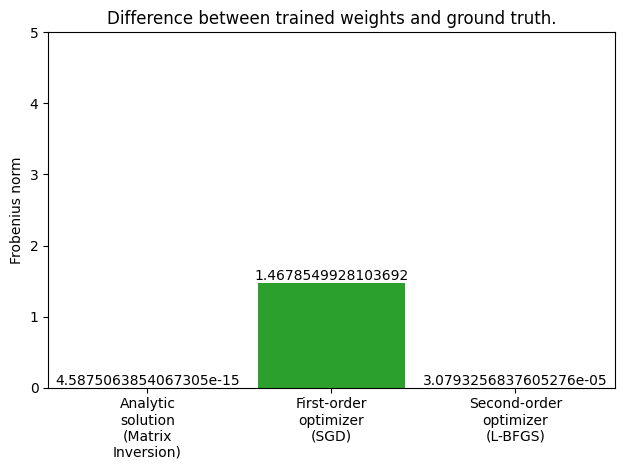

In [14]:
# Final weight comparison using Frobenius norm:
solution_names, solution_norms = zip(
    *[
        (
            solution.value.replace(" ", "\n"),
            np.linalg.norm(
                weights_comparison[solution] - weights_comparison[Solution.ACHIEVABLE]
            ),
        )
        for solution in [Solution.ANALYTIC, Solution.SGD, Solution.LBFGS]
    ]
)
plt.bar(
    x=solution_names,
    height=solution_norms,
    color=["tab:orange", "tab:green", "tab:red"],
)
for i, v in enumerate(solution_norms):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.title("Difference between trained weights and ground truth.")
plt.ylabel("Frobenius norm")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

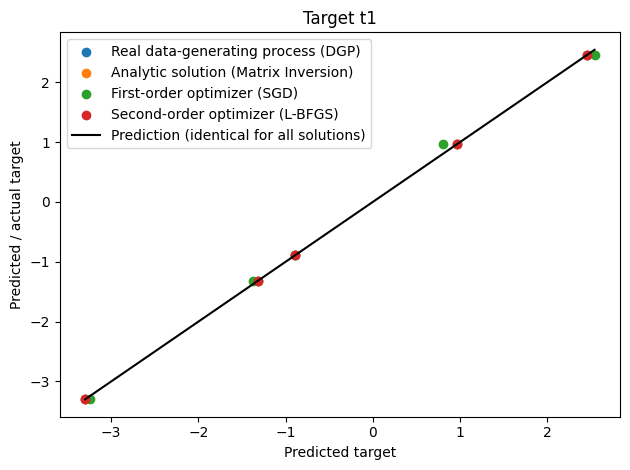

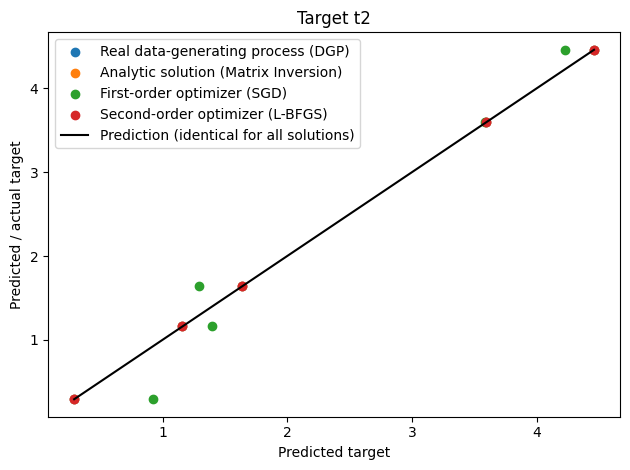

In [15]:
# Final prediction comparison:
for target_col in targets.columns:
    min_prediction = np.inf
    max_prediction = -np.inf
    for solution in [
        Solution.ACHIEVABLE,
        Solution.ANALYTIC,
        Solution.SGD,
        Solution.LBFGS,
    ]:
        prediction = features.dot(weights_comparison[solution])
        plt.scatter(
            prediction[target_col],
            targets[target_col],
            label=f"{solution.value}",
        )
        min_prediction = min(min_prediction, min(prediction[target_col]))
        max_prediction = max(max_prediction, max(prediction[target_col]))
    plt.plot(
        [min_prediction, max_prediction],
        [min_prediction, max_prediction],
        label=f"Prediction (identical for all solutions)",
        color="black",
    )
    plt.xlabel("Predicted target")
    plt.ylabel("Predicted / actual target")
    plt.title(f"Target {target_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


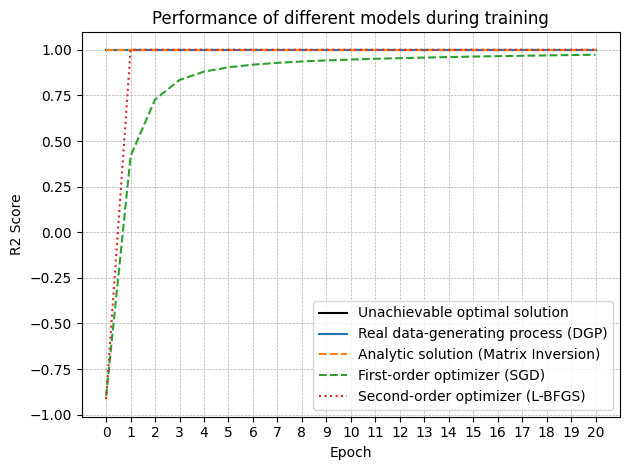

In [16]:
# Track performance metrics during training:
fig, ax = plt.subplots(1, 1)
ax.plot(
    metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].loc[
        :, Solution.UNACHIEVABLE.value
    ],
    color="black",
    linestyle="solid",
    label=Solution.UNACHIEVABLE.value,
)
ax.plot(
    metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].loc[
        :, Solution.ACHIEVABLE.value
    ],
    color="tab:blue",
    linestyle="solid",
    label=Solution.ACHIEVABLE.value,
)
ax.plot(
    metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].loc[
        :, Solution.ANALYTIC.value
    ],
    color="tab:orange",
    linestyle="dashed",
    label=Solution.ANALYTIC.value,
)
ax.plot(
    metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].loc[:, Solution.SGD.value],
    color="tab:green",
    linestyle="dashed",
    label=Solution.SGD.value,
)
ax.plot(
    metric_comparison[METRIC_TO_PERFORM_FINAL_EVALUATION_ON].loc[
        :, Solution.LBFGS.value
    ],
    color="tab:red",
    linestyle="dotted",
    label=Solution.LBFGS.value,
)
ax.legend()
ax.set_title("Performance of different models during training")
ax.set_xlabel("Epoch")
ax.set_ylabel(f"{METRIC_TO_PERFORM_FINAL_EVALUATION_ON} Score")
ax.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)
plt.xticks(range(NUM_TRAIN_EPOCHS + 1))
plt.tight_layout()
plt.show()